In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
#import vaex, numpy as np
from matplotlib.font_manager import FontProperties
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import datetime
import warnings 
#sns.set_style("darkgrid",{"axes.axisbelow" : False })
warnings.simplefilter('ignore')
import string

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from sklearn import metrics

## Loading Dataset

In [3]:
am_metadata = pd.read_csv('official_amazon_metadata.csv')
gr_metadata = pd.read_csv('official_goodreads_metadata.csv')

In [4]:
gr_metadata.loc[gr_metadata['asin'] == '0205739415', 'total_text_reviews_count'] = 1
gr_metadata.loc[gr_metadata['asin'] == '0300084323', 'total_text_reviews_count'] = 1

## Preparing 

In [5]:
am_gr_metadata = pd.merge(gr_metadata[['asin', 'average_rating', 'total_ratings_count', 'total_text_reviews_count', 
                                        'gr_countDes_before', 'gr_countDes_after', 'cleaned_genres',
                                       'gr_countText_before', 'gr_countText_after']], 
                          am_metadata, how='inner', on='asin')

In [6]:
am_gr_metadata = am_gr_metadata.rename(columns={'average_rating':'gr_average', 'total_ratings_count':'gr_ratings_count',
                                                'total_text_reviews_count':'gr_reviews_count', 
                                                'cleaned_genres':'gr_genres',
                                                'average':'am_average', 'rating_count':'am_ratings_count', 
                                                'text_reviews_count':'am_reviews_count', 'genres':'am_genres', 
                                                'rank':'am_rank', 'verifiedTrue_count':'am_verifiedTrue_count', 
                                                'Format':'am_format'})

In [8]:
#Calculating the rating different
am_gr_metadata['rating_diff'] = am_gr_metadata['am_average']- am_gr_metadata['gr_average']

In [9]:
# Replace unnecessary space on gr_genres
am_gr_metadata['gr_genres']= am_gr_metadata['gr_genres'].str.replace(' ','')

In [11]:
am_gr_metadata['total_ratings_count'] = am_gr_metadata['gr_ratings_count'] + am_gr_metadata['am_ratings_count']
am_gr_metadata['total_reviews_count'] = am_gr_metadata['gr_reviews_count'] + am_gr_metadata['am_reviews_count']

In [14]:
data = am_gr_metadata.copy()
data = data[['asin', 'total_ratings_count','total_reviews_count', 'gr_countDes_before', 
             'gr_countText_before', 'am_rank', 'am_verifiedTrue_count','am_countText_before', 
             'rating_diff']]

In [15]:
data

,asin,total_ratings_count,total_reviews_count,gr_countDes_before,gr_countText_before,am_rank,am_verifiedTrue_count,am_countText_before,rating_diff
0,000100039X,221541,10300,106.0,42320,1810945,1130,69909,0.41
1,0001053655,726,135,NaN,158,9799161,43,4888,0.40
2,0001061240,266,81,NaN,49,321557,30,3085,0.25
3,000161102X,2946,92,47.0,130,1542999,13,788,0.49
4,0001711296,845,172,NaN,257,2884610,69,5667,0.15
...,...,...,...,...,...,...,...,...,...
37228,0312953240,100,21,41.0,219,443719,4,2599,-0.11
37229,0312955138,41,16,156.0,125,3470182,6,1489,0.20
37230,0312955154,70,19,48.0,362,3412599,4,1456,-0.07
37231,0312956878,74,19,187.0,152,2606128,9,968,-0.45


In [16]:
# Checking null values
data.isnull().sum()

asin                        0
total_ratings_count         0
total_reviews_count         0
gr_countDes_before       1027
gr_countText_before         0
am_rank                     0
am_verifiedTrue_count       0
am_countText_before         0
rating_diff                 0
dtype: int64

* A rule of thumb : if removing <5% of the observations, free to just remove all that have missing value

In [17]:
data = data.dropna()

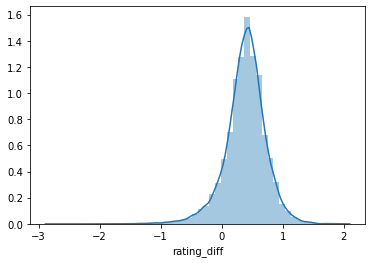

In [18]:
sns.distplot(data['rating_diff'])

=> seems to have outlier on left tails. One way to deal with outlier seemlessly is to remove top 1% of observations

In [21]:
#Deal with outlier
q = data['rating_diff'].quantile(0.01)
data =data[data['rating_diff']>q]

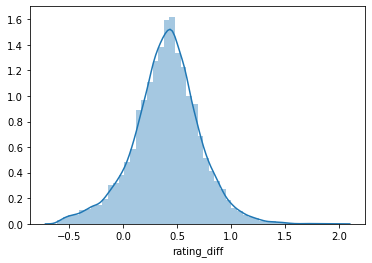

In [22]:
sns.distplot(data['rating_diff'])

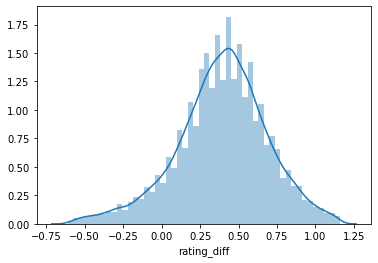

In [23]:
q = data['rating_diff'].quantile(0.99)
data=data[data['rating_diff']<q]
sns.distplot(data['rating_diff'])

In [51]:
#new_df= pd.DataFrame(pd.concat([new_df,new_df['cleaned_genres'].str.get_dummies(sep=',')], axis=1))
new_df = am_gr_metadata[['asin','gr_genres']]
data_with_dummies =  pd.DataFrame(pd.concat([new_df,new_df['gr_genres'].str.get_dummies(sep=',')], axis=1))

In [52]:
am_gr = pd.merge(data,data_with_dummies, on = 'asin', how = 'inner')
am_gr = am_gr.drop(['asin','gr_genres'], axis = 1)

In [53]:
am_gr = am_gr.rename(columns={'non-fiction' : 'non_fiction', 'young-adult': 'young_adult'})

### Spliting the dataset to training and testing 

In [31]:
X = am_gr.drop(["rating_diff"],1)  # feature matrix 
y = am_gr['rating_diff']               # target feature

In [38]:
x_train,x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 365)

In [79]:
import statsmodels.regression.linear_model as smf
import statsmodels.api as sm
#lm = smf.ols(formula= 'rating_diff ~ total_ratings_count + total_reviews_count + gr_countDes_before +  gr_countText_before + am_rank + am_verifiedTrue_count +am_countText_before + rating_diff + biography + children + comics + crime + fantasy + fiction + graphic + historicalfiction + history + mystery + non_fiction + paranormal+ poetry + romance + thriller+ young_adult', data = am_gr).fit()
X = sm.add_constant(x_train)
lm = sm.OLS(y_train,X).fit()

In [80]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rating_diff   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     113.6
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        10:12:46   Log-Likelihood:                -4709.1
No. Observations:               28382   AIC:                             9454.
Df Residuals:                   28364   BIC:                             9603.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3929      0.007     57.136      0.000       0.379       0.406
total_ratings_count    1.892e-07    3.8e-08      4.981      0.000    1.15e-07    2.64e-07
total_reviews_count     -4.7e-06   1.22e-06     -3.864      0.000   -7.08e-06   -2.32e-06
gr_countDes_before     7.673e-05   1.91e-05      4.026      0.000    3.94e-05       0.000
gr_countText_before       -5e-08   1.24e-07     -0.402      0.688   -2.94e-07    1.94e-07
am_rank               -5.629e-09   8.39e-10     -6.707      0.000   -7.27e-09   -3.98e-09
am_verifiedTrue_count  8.622e-05   6.98e-06     12.357      0.000    7.25e-05    9.99e-05
am_countText_before   -1.362e-06   9.69e-08    -14.050      0.000   -1.55e-06   -1.17e-06
biography                -0.0092      0.001     -7.531      0.000      -0.012      -0.007
children                  0.1470      0.006     25.880      0.000       0.136       0.158
comics                    0.0029      0.003      0.907      0.364      -0.003       0.009
crime                    -0.0071      0.001     -4.983      0.000      -0.010      -0.004
fantasy                  -0.0135      0.002     -5.774      0.000      -0.018      -0.009
fiction                  -0.0128      0.005     -2.554      0.011      -0.023      -0.003
graphic                   0.0029      0.003      0.907      0.364      -0.003       0.009
historicalfiction        -0.0092      0.001     -7.531      0.000      -0.012      -0.007
history                  -0.0092      0.001     -7.531      0.000      -0.012      -0.007
mystery                  -0.0071      0.001     -4.983      0.000      -0.010      -0.004
non-fiction               0.0167      0.005      3.109      0.002       0.006       0.027
paranormal               -0.0135      0.002     -5.774      0.000      -0.018      -0.009
poetry                   -0.0161      0.008     -1.987      0.047      -0.032      -0.000
romance                   0.0079      0.005      1.672      0.095      -0.001       0.017
thriller                 -0.0071      0.001     -4.983      0.000      -0.010      -0.004
young-adult               0.0447      0.005      8.570      0.000       0.034       0.055
==============================================================================
Omnibus:                      916.999   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1095.610
Skew:                          -0.399   Prob(JB):                    1.23e-238
Kurtosis:                       3.539   Cond. No.                     5.21e+23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.09e-31. This might indicate that there are


In [60]:
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
y_pred_train = reg.predict(x_train)
print('Train RMSE:')
print(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
r2 = reg.score(x_train,y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print("R^2 adjusted:",adjusted_r2*100)

y_pred_test = reg.predict(x_test)
print('-------------------------')
print('Test RMSE:')
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
r2 = reg.score(x_test,y_test)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)

print("R^2 adjusted:",adjusted_r2*100)
print('')
print("Intercept : ", reg.intercept_)
p_values = f_regression(x_train,y_train)[1]
reg_summary = pd.DataFrame(data=x_train.columns.values, columns = ['Feature'])
reg_summary['Coefficients'] = reg.coef_.round(7)
reg_summary['p-values'] = p_values.round(3)
reg_summary

Train RMSE:
0.2856407384064364
R^2 adjusted: 6.29840333359919
-------------------------
Test RMSE:
0.28820055090539076
R^2 adjusted: 6.822112057618945

Intercept :  0.39288611196022216


,Feature,Coefficients,p-values
0,total_ratings_count,2.000000e-07,0.000
1,total_reviews_count,-4.700000e-06,0.000
2,gr_countDes_before,7.670000e-05,0.001
3,gr_countText_before,-0.000000e+00,0.000
4,am_rank,-0.000000e+00,0.000
5,am_verifiedTrue_count,8.620000e-05,0.000
6,am_countText_before,-1.400000e-06,0.000
7,biography,-9.171600e-03,0.000
8,children,1.469530e-01,0.000
9,comics,2.938200e-03,0.014


## Checking Linear Regression Assumptions

In [62]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

### 1. Linearity

In [63]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


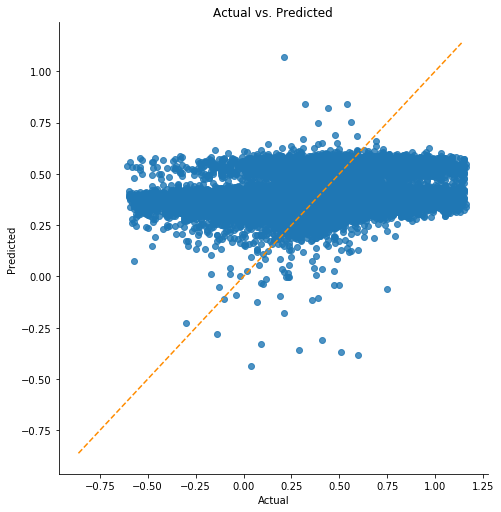

In [64]:
linear_assumption(reg, x_train, y_train)

=> We can see in this case that there is not a linear relationship. 

### 2. Normality of the Error Terms

In [65]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


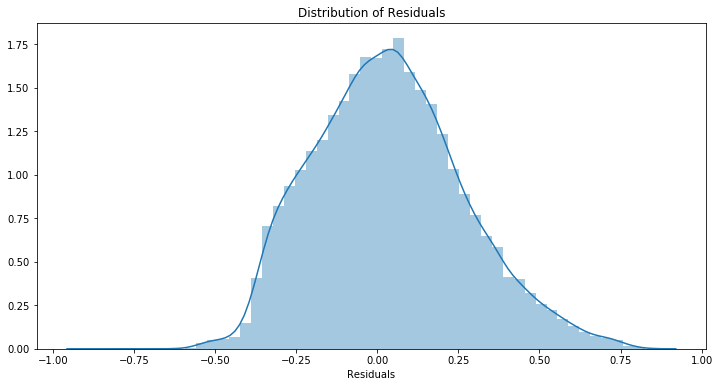


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [66]:
normal_errors_assumption(reg, x_train, y_train)

=> This isn’t ideal, and we can see that our model is biasing towards under-estimating

### 3. No Multicollinearity among Predictors

In [67]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    rcParams['figure.figsize'] = 10, 10
    corr = features.corr()
    f, ax = plt.subplots(figsize=(17,17))

    sns.heatmap(corr,cmap=sns.diverging_palette(20, 220, n=200),
                annot=True,
                fmt=".2f",
                annot_kws={'size':11},
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .71},
                 vmin=-1, vmax=1)
    ax.set_xlabel('Amazon+Googread Feature', fontsize = 20)
    ax.set_ylabel('Amazon+Goodread Feature', fontsize = 20)
    ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
    #cbar_ax.yaxis.label.set_size(20)
    ax.figure.axes[-1].set_ylabel('', size=20)
    plt.title('Heat Map for the Pearson corr', fontsize = 20, weight = 'bold')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(features.values,i) for i in range(features.shape[1])]
    vif['features'] = features.columns
    print(vif)
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in vif['VIF'] if vif > 10])
    definite_multicollinearity = sum([1 for vif in vif['VIF'] if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

Assumption 3: Little to no multicollinearity among predictors


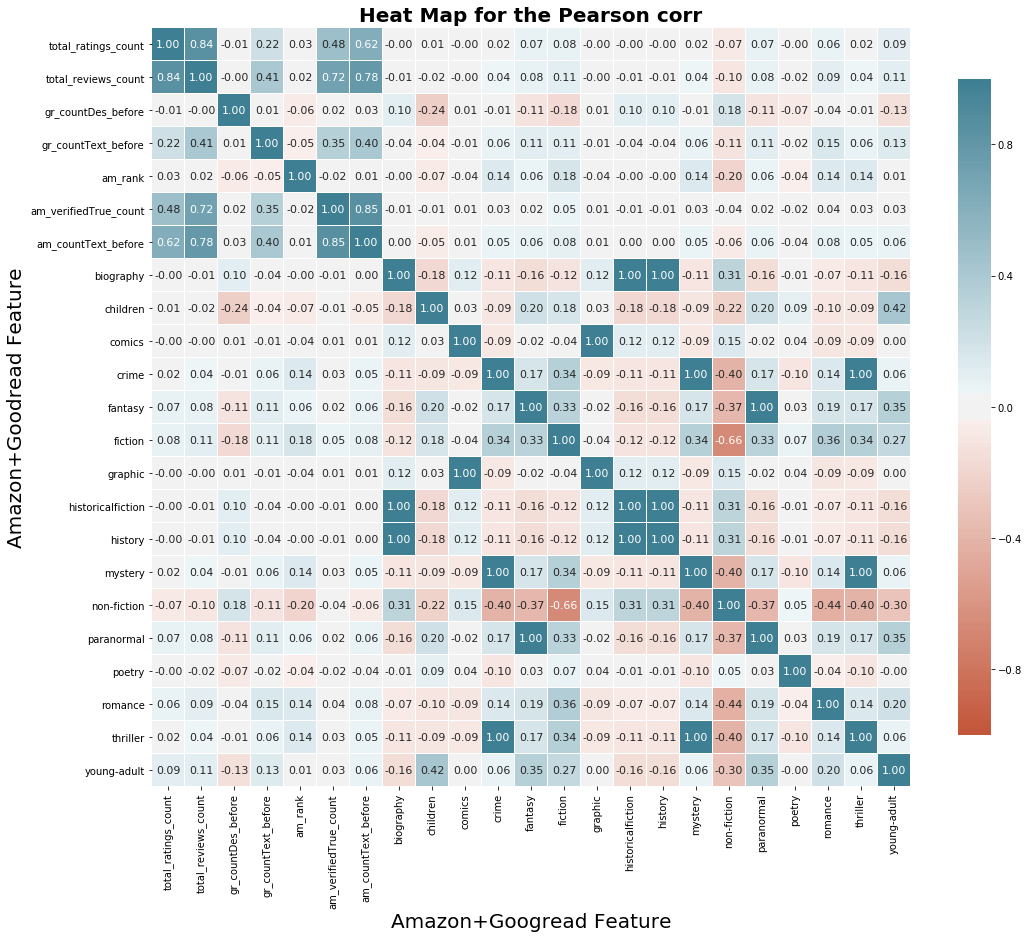

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
         VIF               features
0   4.330743    total_ratings_count
1   7.373356    total_reviews_count
2   3.403729     gr_countDes_before
3   1.426048    gr_countText_before
4   1.577581                am_rank
5   4.593340  am_verifiedTrue_count
6   5.729490    am_countText_before
7        inf              biography
8   1.621071               children
9        inf                 comics
10       inf                  crime
11       inf                fantasy
12  3.956607                fiction
13       inf                graphic
14       inf      historicalfiction
15       inf                history
16       inf                mystery
17  2.789086            non-fiction
18       inf             paranormal
19  1.099992                 poetry
20  1.742603                romance
21       inf              

In [68]:
multicollinearity_assumption(reg, x_train, y_train,x_train.columns)

=> The only variables that have high VIF is dummy variables. We can ignore it.  
SOURCE : https://statisticalhorizons.com/multicollinearity

### 4. No Autocorrelation of the Error Terms

In [69]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [70]:
autocorrelation_assumption(reg, x_train, y_train)

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.9401681727839557
Little to no autocorrelation 

Assumption satisfied


### 5. Homoscedasticity

In [71]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


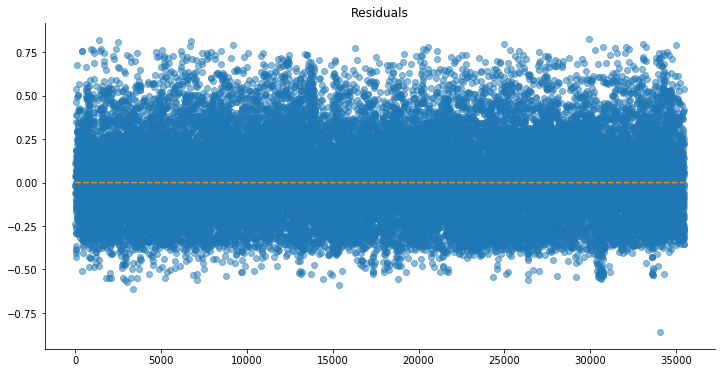

In [72]:
homoscedasticity_assumption(reg, x_train, y_train)

=> We can see a fully uniform variance across our residuals. There don’t appear to be any obvious problems with that.

### Conclusion 
We can clearly see that a linear regression model on the dataset still violates a number of assumptions which cause significant problems with the interpretation of the model itself.  
Assumptions that are violated :
 * Linearity
 * Normality of the Error Terms

Assumptions that aren't violated:
 *  No Autocorrelation of the Error Terms
 *  Homoscedasticity
 *  No Multicollinearity among Predictors
 
=> R^2 adjusted increased after adding genres dummies which means the new terms improve the model fit 